<a href="https://colab.research.google.com/github/GabyDs/FirearmShotDetectionSystem/blob/main/FirearmShotDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [29]:
import os

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
from scipy import signal

from IPython.display import Audio
from scipy.io import wavfile

# Dataset

In [ ]:
!wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t" -O train.zip

In [ ]:
!unzip train.zip

# Explore Dataset

In [5]:
# Function to check and convert a loaded audio to the appropriate sample_rate (16K); otherwise, it would impact the model results.
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  try:
    if waveform.shape[1] > 1:
        # Only one chammel, allows MONO
        waveform = wav_data[:,0]
  except:
    # It's MONO then, does not have 2nd dimension
    pass
  return desired_sample_rate, waveform

## Listen to the sound

In [35]:
# Shoot
wav_file_name = '/content/Audios_disparos_selva/train/disparos/58FFBD118f732e71-d74e-4f86-aee4-9712fe2d7a64.WAV'

# Background
#wav_file_name = '/content/Audios_disparos_selva/train/fondo/5C0305B1.WAV'

sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
#sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Basic file information.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# To play and verify.
Audio(wav_data, rate=sample_rate)

Sample rate: 8000 Hz
Total duration: 4.00s
Size of the input: 32000


## visualize the spectrum

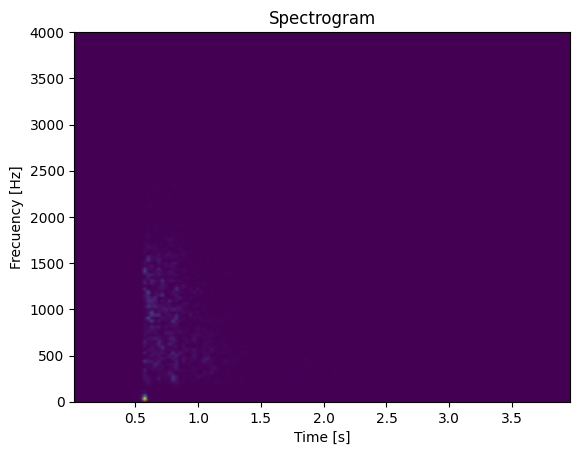

In [36]:
f, t, Sxx = signal.spectrogram(wav_data, sample_rate)

plt.pcolormesh(t, f, Sxx, shading='gouraud')

plt.title("Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frecuency [Hz]")

plt.show()